<a href="https://colab.research.google.com/github/blazklobucar/HistoricalTrees/blob/main/UNetForHistoricalTrees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UNet for mapping of Historical Trees
### Author: Ankit Kariryaa, University of Copenhagen

In [ ]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import rasterio

import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = get_device()


In [ ]:
device

device(type='cuda')

In [ ]:
class HistoricalTrees(Dataset):
    """
    Dataset for historical trees
    """

    def __init__(
        self,
        image_dir: str,
        annotation_dir: str,
        split:str = "train",
        Xmax = None,
        Xmin = None,
        normalize:bool = True,
        device = 'cpu'
    ) -> None:
        self.split = split
        # The expected data path is data/train/IM_1.tif ...
        # Original: self.images = glob(os.path.join(image_dir, split, 'IM_*.tif'))

        # For testing remove later
        self.images = glob(os.path.join(image_dir, split, 'IM_*.jpg'))
        # End testing
        print(self.images)
        annotations = []
        for im in self.images:
            name = os.path.splitext(os.path.basename(im))[0].replace("IM_", "")
            annotations.append(os.path.join(annotation_dir, split, f"TARGET_{name}.jpg")) # Change to .tif
        self.annotations = annotations
        # Store in the class for future reference
        self.Xmax  = Xmax
        self.Xmin = Xmin
        self.normalize = normalize

    def __len__(self):
        return len(self.images)


    def read_file(self, im, norm):
        """
        Reads and stacks our data
        """
        r1 = rasterio.open(im)
        r =  r1.read()
        if norm and self.Xmax is not None and  self.Xmin is not None:
            r = (r - self.Xmin) / (self.Xmax - self.Xmin)
        return r

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        X = self.read_file(self.images[idx], norm= self.normalize)
        # Original:  y =  (self.read_file(self.annotations[idx], norm=False).astype(np.int32)

        # For testing
        y =  self.read_file(self.annotations[idx], norm=self.normalize)
        y = y[0]
        y[y>0.3] = 1
        y[y<=0.3] = 0
        # Remove testing later


        sample = {'X': torch.FloatTensor(X), 'y': torch.FloatTensor(y)}
        return sample

In [ ]:
base_path = "./HistoricalTreesProject/" # Define it

Xmax = np.array([255])
Xmax = Xmax.reshape((1, 1, 1))
Xmin = np.array([0])
Xmin = Xmin.reshape((1, 1, 1))
normalize= True

p_train = HistoricalTrees(os.path.join(base_path, "data", "images"),
                             os.path.join(base_path, "data", "annotations"),
                             split="train",
                             Xmax = Xmax,
                             Xmin = Xmin,
                             normalize = normalize,
                            )

p_val = HistoricalTrees(os.path.join(base_path, "data", "images"),
                             os.path.join(base_path, "data", "annotations"),
                             split="val",
                             Xmax = Xmax,
                             Xmin = Xmin,
                             normalize= normalize,
                            )

p_test = HistoricalTrees(os.path.join(base_path, "data", "images"),
                             os.path.join(base_path, "data", "annotations"),
                             split="test",
                             Xmax = Xmax,
                             Xmin = Xmin,
                             normalize= normalize,
                            )


['./HistoricalTreesProject/data/images/train/IM_1.jpg', './HistoricalTreesProject/data/images/train/IM_12.jpg']
['./HistoricalTreesProject/data/images/val/IM_2.jpg', './HistoricalTreesProject/data/images/val/IM_22.jpg']
['./HistoricalTreesProject/data/images/test/IM_3.jpg', './HistoricalTreesProject/data/images/test/IM_32.jpg']


In [ ]:
# Create a dataloader from the dataset
# Dataloader gives us the possibility to sample a mini-batches instead of only a single sample
BATCH_SIZE = 2 # Adjust the batch to fit the VRAM of the GPU
# If your BATCH_SIZE is too small then compensate for it by increasing the grad_accumulation in the training step

num_workers = 8 # Change depending upon the available hardware
train_dataloader = DataLoader(p_train, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=num_workers)

val_dataloader = DataLoader(p_val, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=num_workers)

test_dataloader = DataLoader(p_test, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=num_workers)


In [ ]:
for d in train_dataloader:
    print(d['X'].shape, d['y'].shape, )
    print(d['X'].dtype, d['y'].dtype, )
    break

/home/ankit/miniconda3/envs/delfors_new/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


torch.Size([2, 3, 480, 480]) torch.Size([2, 480, 480])
torch.float32 torch.float32


/home/ankit/miniconda3/envs/delfors_new/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


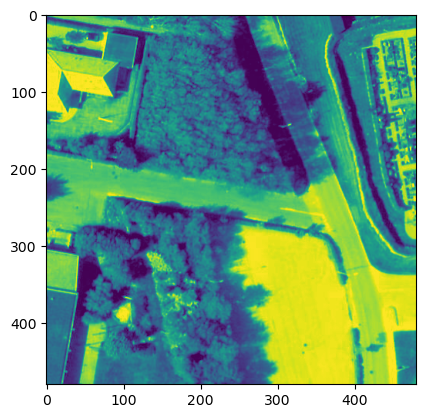

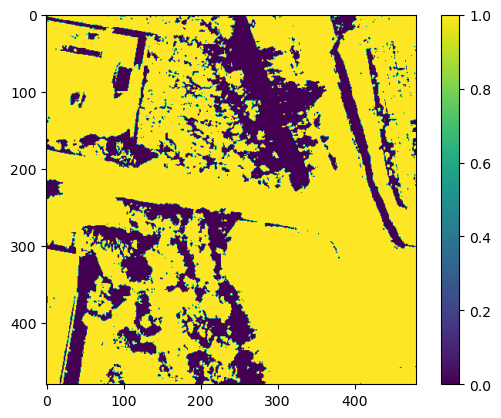

In [ ]:
imd = 0
# Show the 3rd band of the third image
plt.imshow(p_train[imd]['X'][0].cpu().numpy())
plt.show()

# Show the labels for third image
plt.imshow(p_train[imd]['y'].cpu().numpy())
plt.colorbar()
plt.show()

# Neural Network

In [ ]:
# Define our neural network

# Modified from: https://github.com/milesial/Pytorch-UNet
# GPL-3 license

class DoubleConv(nn.Module):
    """(convolution => [BN] => ELU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
#             nn.LayerNorm(mid_channels),
            nn.ELU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
#             nn.LayerNorm(out_channels),
            nn.ELU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [ ]:
# Define the evaluation loop
def eval_loop(model, val_loader, criterion):
#     print(f"Validating using the val_loader")
    epoch_loss_val = []
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            x, y_true = batch['X'].to(dtype=torch.float32, device=device), batch['y'].to(device=device)
            y_true = torch.unsqueeze(y_true, dim=1)
            y_pred = model(x)

            ### Calcualte loss
            loss = criterion(y_pred, y_true)
            epoch_loss_val.append(loss.item())
    el = torch.mean(torch.FloatTensor(epoch_loss_val))
    model.train()
    return el

# Define the training loop
def train_loop(model, train_loader, val_loader, optimizer, criterion, epochs=50, grad_accumulation=1):
    train_loss = []
    val_loss = []
    n_train =  len(train_loader)
    for e in range(epochs):
        epoch_loss_train = []
        model.train()
        for batch_idx, batch in enumerate(train_loader):
            print(f"Training on Batch: {batch_idx}")
            x, y_true = batch['X'].to(dtype=torch.float32, device=device), batch['y'].to(device=device)
            y_true = torch.unsqueeze(y_true, dim=1)
            y_pred = model(x)
#             import ipdb; ipdb.set_trace()

            ### Calcualte loss
            loss = criterion(y_pred, y_true)
            loss.backward()

            if (batch_idx + 1) % grad_accumulation == 0 or (batch_idx + 1 == n_train):
                    optimizer.step()
                    optimizer.zero_grad()

            epoch_loss_train.append(loss.item())

        el = torch.mean(torch.FloatTensor(epoch_loss_train))
        print(f"Train loss for epoch {e}: {el}")
        train_loss.append(el)

        vel = eval_loop(model, val_loader, criterion)
        print(f"Validation loss for epoch {e}: {vel}")
        val_loss.append(vel)

    return model, train_loss, val_loss

In [ ]:
# Define our first model
input_size = 3 # Change it
output_size = 1

model = UNet(n_channels = input_size, n_classes = output_size)
model.to(device=device)
# Define the optimizer, the loss function and
lr = 0.0001 # The learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=lr) # Optimizer calculates the gradients and use it to update the model weights.
criterion = nn.BCEWithLogitsLoss(reduction='mean')

In [ ]:
# Train the model
start_time = time.time()
epochs = 200

grad_accumulation = 4 # Accumulate grad over 4 batches

#Train the model for 50 epochs with CrossEntropry loss.
model, train_loss, val_loss = train_loop(model, train_dataloader, val_dataloader,  optimizer, criterion, epochs=epochs, grad_accumulation=grad_accumulation)
print(f"Trained for {epochs} epochs in {time.time()-start_time} seconds")

Training on Batch: 0
Train loss for epoch 0: 0.23185713589191437
Validation loss for epoch 0: 0.39898309111595154
Training on Batch: 0
Train loss for epoch 1: 0.22738657891750336
Validation loss for epoch 1: 0.3827289640903473
Training on Batch: 0
Train loss for epoch 2: 0.22328166663646698
Validation loss for epoch 2: 0.3842983841896057
Training on Batch: 0
Train loss for epoch 3: 0.21929197013378143
Validation loss for epoch 3: 0.36686941981315613
Training on Batch: 0
Train loss for epoch 4: 0.2155202180147171
Validation loss for epoch 4: 0.34480997920036316
Training on Batch: 0
Train loss for epoch 5: 0.21180634200572968
Validation loss for epoch 5: 0.33425173163414
Training on Batch: 0
Train loss for epoch 6: 0.2083304524421692
Validation loss for epoch 6: 0.31516778469085693
Training on Batch: 0
Train loss for epoch 7: 0.2049035280942917
Validation loss for epoch 7: 0.3091658353805542
Training on Batch: 0
Train loss for epoch 8: 0.20181454718112946
Validation loss for epoch 8: 0.2

Validation loss for epoch 71: 0.14864474534988403
Training on Batch: 0
Train loss for epoch 72: 0.12920238077640533
Validation loss for epoch 72: 0.14704926311969757
Training on Batch: 0
Train loss for epoch 73: 0.12853321433067322
Validation loss for epoch 73: 0.14735980331897736
Training on Batch: 0
Train loss for epoch 74: 0.12772461771965027
Validation loss for epoch 74: 0.1483049839735031
Training on Batch: 0
Train loss for epoch 75: 0.12708814442157745
Validation loss for epoch 75: 0.14623838663101196
Training on Batch: 0
Train loss for epoch 76: 0.12634184956550598
Validation loss for epoch 76: 0.14654721319675446
Training on Batch: 0
Train loss for epoch 77: 0.12561891973018646
Validation loss for epoch 77: 0.14726576209068298
Training on Batch: 0
Train loss for epoch 78: 0.12504634261131287
Validation loss for epoch 78: 0.14686696231365204
Training on Batch: 0
Train loss for epoch 79: 0.12458435446023941
Validation loss for epoch 79: 0.14725282788276672
Training on Batch: 0
Tr

Training on Batch: 0
Train loss for epoch 142: 0.08961162716150284
Validation loss for epoch 142: 0.14648762345314026
Training on Batch: 0
Train loss for epoch 143: 0.08914300799369812
Validation loss for epoch 143: 0.14624136686325073
Training on Batch: 0
Train loss for epoch 144: 0.08869625627994537
Validation loss for epoch 144: 0.14443926513195038
Training on Batch: 0
Train loss for epoch 145: 0.08829004317522049
Validation loss for epoch 145: 0.14754565060138702
Training on Batch: 0
Train loss for epoch 146: 0.08785121142864227
Validation loss for epoch 146: 0.1455792635679245
Training on Batch: 0
Train loss for epoch 147: 0.08747436851263046
Validation loss for epoch 147: 0.14636459946632385
Training on Batch: 0
Train loss for epoch 148: 0.08717193454504013
Validation loss for epoch 148: 0.15046271681785583
Training on Batch: 0
Train loss for epoch 149: 0.08688046038150787
Validation loss for epoch 149: 0.14356127381324768
Training on Batch: 0
Train loss for epoch 150: 0.08631774

In [ ]:
prd = model(p_val[0]['X'].unsqueeze(0).to(device))

In [ ]:
prd.shape

torch.Size([1, 1, 480, 480])

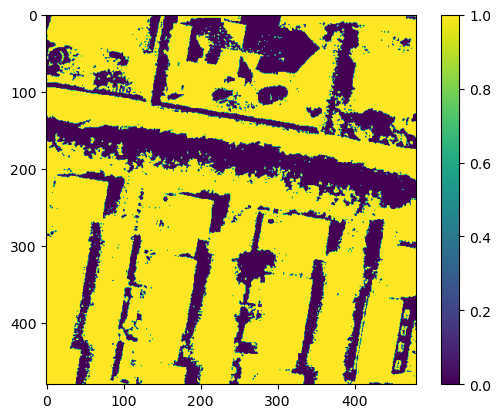

In [ ]:
plt.imshow(torch.sigmoid(prd[0,0]).detach().cpu().numpy() > 0.5)
plt.colorbar()
plt.show()

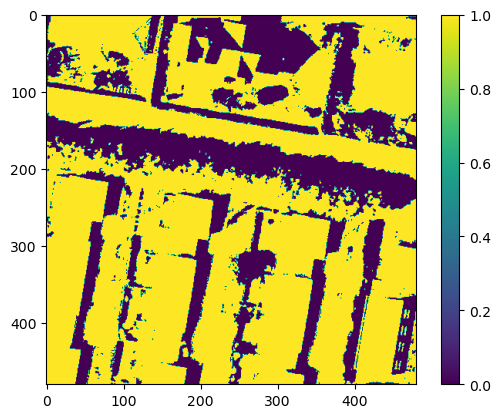

In [ ]:
plt.imshow(p_val[0]['y'])
plt.colorbar()
plt.show()